<a href="https://colab.research.google.com/github/Selii341/COSC2793A2/blob/main/Week6_lab_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# <div align="center"><font color='green'>  </font></div>
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Week 6 Lab Exercises: **Neural Networks (MLP)**</font></div>
---

# Introduction

In this lab you will be:
1. Learning how to use Keras API (in tensorflow library).  
2. Implement simple NN to classify images in the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="CIFAR10IMG.png" alt="drawing" width="400"/>

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

**In this lab we will only use a subset of CIFAR10 data that has 10000 images.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/'My Drive'/COSC2793/ass2/trafficsigns_dataset.zip .

Mounted at /content/drive


# Reading Data

The data is available on Canvas. You can upload it to the notebook work environment and unzip using the following code.

In [ ]:
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

The dataset consists of the images and a csv file. The labels and the image paths are in the CSV file.

Lets randomly split the data into train/val/test

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./CIFAR_Data.csv')

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 6000, Val Data: 2000, Test Data: 2000


# EDA

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Do the EDA and identify the suitable performance measure. </font>**  

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Plot some images from the dataset and observe. </font>**  


# Model development

As discussed in Week 4-5, the typical ML model development process consists of 4 steps, lets go through each and see how it is done.

1. **Determine your goals**: Performance metric and target value. Problem dependent.

2. **Setup the experiment**: Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

3. **Default Baseline Model**: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

4. **Make incremental changes**: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation.

So far we conducted the EDA and accordingly we can decide that a performance measure such as Accuracy is adequate for this task. This is justified by the observation that there is no label imbalance in our dataset and the task is multi-class classification. According to the CIFAR website others have achieved around 82% accuracy for the full dataset. Therefore we can set that as the target performance value. However this might be unrealistic given:

- We are only using a subset of data in this lab (10000/50000) to train the model.
- We are using a traditional neural network (not CNN).
- No data augmentation.

For a traditional NN the a 50% accuracy target will be more realistic.

We have also identified the train/test/val splits and ready to do the experiments. In developing a neural network, we can use the learning curves to identify the next action to take. so let’s write a simple function to plot the learning curve of a NN training process. This will be our diagnostic tool.

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Base Model

Next we need to establish a base model. In this lab we focus on MLP, therefore let’s setup a simple MLP. In this network let’s set the hidden layer dimension to 256. This is a hyper parameter and we can tune it later.

In [ ]:
INPUT_DIM = (32,32,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 10

Now we are ready to setup out NN model. We will use tensorflow to build our neural network and train. To be precise, we will be using Keras which is a high level API which is part of tensorflow. First we need to setup and use Keras. In AWS Sagemaker you can change the ipython notebook kernel to `conda\_tensorflow\_p36` which will load a kernel that include Keras and Tensorflow. Typically this is not installed by default in the local anaconda environment.

## Setup Keras locally
**Ignore this section if you are on AWS or colab**

Anaconda does not come with the Neural Network and Deep Learning packages installed by default, therefore we are going to have to install them ourselves. To install, open Anaconda, and select the `Envrionments` tab from the left-hand bar.
This tab lists all of the python and sci-kit learn packages that are installed on your machine, and all available packages to install.

<img src="install-01.png" alt="drawing" width="200"/>

Leave the `base(root)` environment selected.
*(If you really want to keep the deep learning packages separate you can create a new environment. This makes it easier to clean-up these packages later, but will consume more disk-space. You will also need to ensure you are in the correct environment when you launch Jupyter).*

We need to install the package:
1. tensorflow


Tensorflow is an Open Source Software Library for Machine Intelligence.
Keras is a high-level neural networks API specification (in tensorflow), implemented in Python and capable of running on top of either TensorFlow or Theano.
We will be using Keras and Tensorflow as the backend throughout the lab.
It was developed with a focus on enabling fast experimentation and it allows to go from idea to result with the least possible delay without worrying about the numerical details of floating point operations, tensor algebra and GPU programming.

To install the packages, select `All`, from the drop-down

<img src="install-02.png" alt="drawing" width="200"/>

Search for `tensorflow` and select the check-mark to note the package should be installed.

<img src="install-03.png" alt="drawing" width="400"/>

Finally click `Apply` at the bottom-right corner, and confirm the installation in the pop-up window.
This will install all of the necessary packages, and make take some time.

To test your installation

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.15.0'

You should see the version number as output. It should be grater than 2.0.0

Building the neural network requires configuring the layers of the model, then compiling the model and finally training the model.

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most neural networks consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

A layer in the MLP is represented by `tf.keras.layers.Dense`. First lets define the dimensions of our neural network.


There are three ways to build a model in tensorflow:
 - Functional API
 - Sub-classing
 - Sequential API

We will use the `Sequential` API to build models as it is the simplest.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 * 3 = 3072 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected (MLP), neural layers. The first Dense layer has 256 nodes (or neurons). The second (and last) layer returns a logits array with length of 4. Each node contains a score that indicates the current image belongs to one of the 4 classes.

We can use `model.summary()` to print the model that was created.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 789258 (3.01 MB)
Trainable params: 789258 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The `tf.keras.utils.plot_model` shows the model as a figure

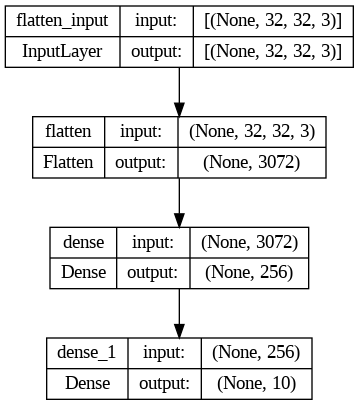

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Read the tensorflow documentation on `Sequential` models [url](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). </font>**  

### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Read the tensorflow documentation on `losses` models [url](https://www.tensorflow.org/api_docs/python/tf/keras/losses) to identify other possible options for loss. </font>**  

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Read the tensorflow documentation on `metrics` models [url](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) to identify other possible options for metric. </font>**  

### Train the model
Now we are ready to train the model. As are going to work with much larger and more complicated data set, that neural network are more suited towards, we need to write efficient code to load the data in batches to memory. This is done in keras using Image data generators.

To help we will define a loading function that takes the data frames we defined earlier:

We can use the `flow_from_dataframe` function in the keras data loader to load a set of images directly from a pandas data frame (the data frame should contain the image names (path) and the labels)

For some reason ImageDataGenerator need the labels to be in string format. Lets do that

In [ ]:
train_data['Class'] = train_data['Class'].astype('str')
val_data['Class'] = val_data['Class'].astype('str')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 6000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


With this, the training the validation data can be loaded.
You will need to supply the appropriate directory. Usually each pixels varies from 0-255, but it's highly recommended to normalize them in range of 0-1 to speed up the training process.
The dataloader also do a simple normalisation on the pixel values directly.

Now we can use a simple model.fit\_generator() in Keras to train the model.

In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

<ipython-input-13-243f5d5117d3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


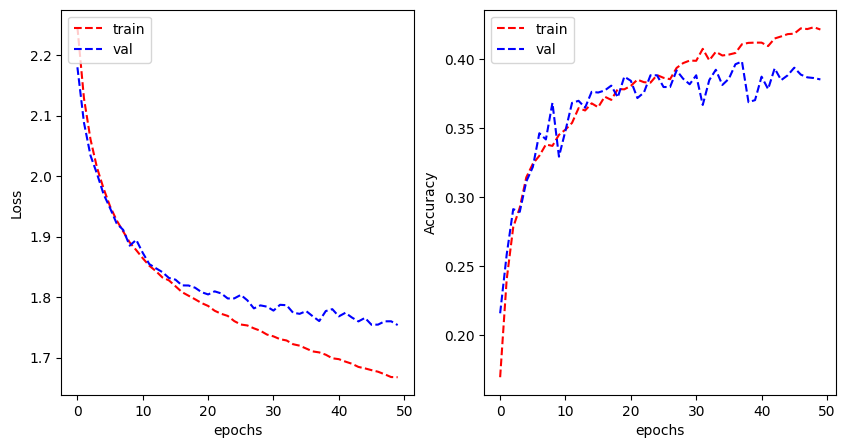

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

Now you know how to setup a neural network and train it in tensorflow.

### Incremental changes
Next step is doing the incremental updates to improve the performance. Observe the loss curves and act accordingly. Some options are.

**If the model is under fitting:**
1. Increase the number of neurones in the hidden layer
2. Increase the number of hidden layers

**If the model is over fitting:**
1. Add regulatization: Lasso/Ridge penalty
2. Add dropout
3. Reduce number of neurones in each layer or number of layers.

Some of the steps are done in the LectureQandA code for week 9 module - neural networks. You can get the basic syntax from there and implement accordingly.


> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Tune the neural network model to get the best performance possible. </font>**  

# Testing the final model

Now lets test our final model on the test data.

First we will create a data generator to get the test data

In [ ]:
test_data['Class'] = test_data['Class'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="Class",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 validated image filenames belonging to 10 classes.


In [ ]:
model.evaluate(test_generator)

2000/2000 [==============================] - 5s 3ms/step - loss: 1.7244 - categorical_accuracy: 0.4000


[1.7243726253509521, 0.4000000059604645]

## Ploting some results

Lets visualize the output of our network.

In [ ]:
label_names = {'airplane' : 0, 'automobile' : 1, 'bird' : 2, 'cat' : 3, 'deer' : 4, 'dog' : 5, 'frog' : 6, 'horse' : 7, 'ship' : 8, 'truck' : 9}

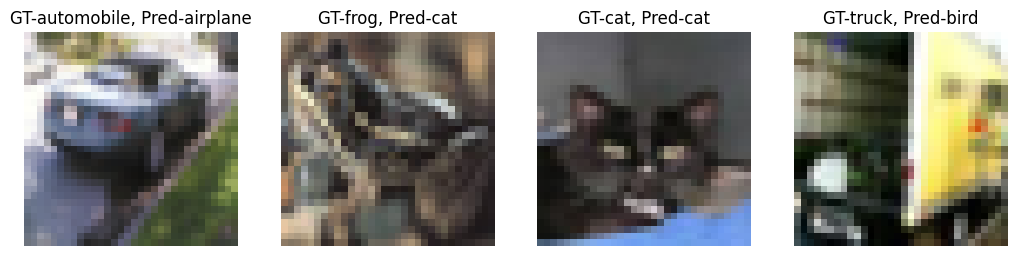

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')